# Basic model

author: laquitainesteeve@gmail.com

execution time:

tested on Apple M4 16GB RAM (no GPU required)

## Setup 

activate fisher_info_limits

In [245]:
# import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle5 as pickle
from scipy.stats import spearmanr, wilcoxon
from matplotlib.gridspec import GridSpec as GS
import math
from scipy.stats import poisson
from scipy.optimize import minimize_scalar
from scipy.special import radian as rad
from scipy.stats import circstd
from tqdm import tqdm
from scipy.special import gammaln

# setup project path
main_dir = '/Users/steeve_laquitaine/Desktop/CARLO/code/fisher-info-limits/'
os.chdir(main_dir)

# import custom package
import ssiProjectModule as ssiMod

# setup parameters
sample_size = 500
theta_step = 2
stim = np.arange(0, 360, theta_step) # stimulus direction space

# setup Bayesian parameters
N_TRIALS = 500

# setup paths
main_dir = '/Users/steeve_laquitaine/Desktop/CARLO/code/fisher-info-limits/'
dat_dir_in = main_dir + 'data/decoding_analysis/'
data_dir = 'data/bayer_decoding_error/'+f'Bayes_Dec_Errs_{sample_size}reps_thetastep{theta_step}'+'.npz'

title = f'Stretch_BioQuads_multiplied_w_mean_g__theta_step={theta_step}_original_g_20240509_AREA.pkl'

constant = 360/np.sqrt(2*np.pi*math.e)

with open(dat_dir_in + title, 'rb') as rick:
    data_dict = pickle.load(rick)

bio_idx = np.where(data_dict['all_multipliers']==1.)[0][0]

chosen_quads = np.array([201, 125, 104, 491])

## Functions

In [238]:
# Bayesian decoder

def generate_responses(tuning_curves, true_direction_index, n_trials=10, seed=0):
    """
    Generate Poisson spike counts for all neurons given a true direction.
    
    Parameters:
    - true_direction_index: true motion direction index 
    - n_trials: number of trials to simulate
    
    Returns:
    - responses: array of spike counts [n_trials, n_neurons]
    """
    # setup reproducibility
    np.random.seed(seed)

    # parameters
    n_neurons = tuning_curves.shape[1]
    responses = np.zeros((n_trials, n_neurons))
    
    for n_i in range(n_neurons):
        mean_firing_rate = tuning_curves[true_direction_index, n_i]
        responses[:, n_i] = poisson.rvs(mean_firing_rate, size=n_trials)
    return responses


def log_likelihood(direction_index, responses, tuning_curves):
    """Compute log likelihood of observed responses given a direction.
    
    Parameters:
    - direction (float): candidate direction (degrees)
    - responses: observed spike counts for all neurons
    
    Returns:
    - log_likelihood: log probability of the data
    """
    n_neurons = tuning_curves.shape[1]
    direction_index = int(direction_index) # make an integer 

    log_prob = 0
    
    # Poisson log likelihood ( sum(r * ln(mean_r) - mean_r) )
    for n_i in range(n_neurons):
        mean_firing_rate = tuning_curves[direction_index, n_i]
        log_prob += responses[n_i] * np.log(mean_firing_rate + 1e-10) - mean_firing_rate - gammaln(responses[n_i] + 1)
    return log_prob


def compute_likelihood(responses, tuning_c):
    """Calculate likelihoods for all candidate directions given responses.
    
    Args:
        responses (np.array): vector of n neurons responses
        tuning_c (np.array): tuning curve matrix of shape (n_directions, n_neurons)
    """
    n_stim = tuning_c.shape[0]
    llh = []
    for candidate_dir_ix in range(n_stim):
        llh.append(log_likelihood(candidate_dir_ix, responses, tuning_c))
    return np.exp(np.array(llh))


def get_circular_mean(prob, directions):
    """Simplest form assuming 360 evenly spaced directions from 0° to 359°
    """
    # get directions
    dir = np.deg2rad(directions)
    
    # normalize probabilities
    prob = prob / np.sum(prob)
    
    # calculate components
    x = np.sum(prob * np.cos(dir))
    y = np.sum(prob * np.sin(dir))
    
    # return mean in degrees
    return np.degrees(np.arctan2(y, x)) % 360


def decode_direction(responses, tuning_c, stim):
    llh = compute_likelihood(responses, tuning_c)
    return get_circular_mean(llh, stim)


def compute_bayesian_decoding_error(true_directions, tuning_c, n_trials=100, seed=0):

    all_true_dirs = []
    all_decoded_dirs = []
    all_errors_deg = []
    all_errors_rad = []

    # loop over stimulus in stimulus space
    for dir_ix, true_dir in tqdm(enumerate(true_directions), total=len(true_directions)):

        # (n trials, 4 neurons) responses
        responses = generate_responses(tuning_c.T, int(dir_ix), n_trials=n_trials, seed=seed)

        # loop over many trials
        for trial in range(n_trials):
            
            #llh = compute_likelihood(responses[trial,:], tuning_c.T)
            #decoded_dir = get_circular_mean(llh, stim)
            decoded_dir = decode_direction(responses[trial,:], tuning_c.T, stim)
            
            # # decode each trial
            # decoded_dir_ix = decode_direction(responses[trial,:], 
            #                                   tuning_c.T, 
            #                                   bounds=(0, len(true_directions)-1))
            # decoded_dir = true_directions[decoded_dir_ix]

            # compute circular error
            error_deg = min(abs(decoded_dir - true_dir), 360 - abs(decoded_dir - true_dir))       
            error_rad = rad(error_deg, 0, 0)

            # record direction x trials
            all_true_dirs.append(true_dir)
            all_decoded_dirs.append(decoded_dir)
            all_errors_deg.append(error_deg)         
            all_errors_rad.append(error_rad)      

    all_true_dirs = np.array(all_true_dirs)
    all_decoded_dirs = np.array(all_decoded_dirs)
    all_errors_deg = np.array(all_errors_deg)
    all_errors_rad = np.array(all_errors_rad)

    # calculate estimate errors as std
    stds_deg = []
    stds_circ = []
    
    for _, true_dir in enumerate(true_directions):

        this_true_dir_pos = all_true_dirs== true_dir
        
        # method 1: std over degrees
        std_deg = np.sqrt((all_errors_deg[this_true_dir_pos]**2).mean())
        
        # method 2: circular std over radians
        std_circ = circstd(all_errors_rad[this_true_dir_pos])
        
        # record
        stds_deg.append(std_deg)
        stds_circ.append(std_circ)

    stds_deg = np.array(stds_deg)
    stds_circ = np.array(stds_circ)

    return {
        'true_directions': all_true_dirs,
        'decoded_directions': all_decoded_dirs,
        'errors_deg': all_errors_deg,
        'errors_rad': all_errors_rad,
        'stds_deg': stds_deg,
        'stds_circ': stds_circ
    }

## Compute dataset

### Tuning curves

In [239]:
# setup parameters
N_NEURONS = 4
AMPLITUDE = 4000
WIDTH = 0.5
BASELINE = 0

# setup the preferred angle of each neuron
preferred_angles = np.linspace(0, 360, N_NEURONS, endpoint=False) 
print('Preferred angles:', preferred_angles)

# create tuning curves
tuning_c = []
for ix, pref_angle  in enumerate(preferred_angles):
    tuning_c.append(ssiMod.VON_MISES(th=stim, a=AMPLITUDE, th_0=pref_angle, s=WIDTH, baseline=BASELINE))
tuning_c = np.array(tuning_c)
print("tuning curve shape:", tuning_c.shape)

Preferred angles: [  0.  90. 180. 270.]
tuning curve shape: (4, 180)


## Compute metrics

### Fisher error

In [243]:
%%time 

# compute fisher information
fisher_info = ssiMod.FISHER_POISSON(stim, tuning_c)
print("Fisher info shape:", fisher_info.shape)

# compute fisher error (flat prior, unbiased estimator)
fisher_error = 1/np.sqrt(fisher_info)

Fisher info shape: (180,)
CPU times: user 1.18 ms, sys: 1.23 ms, total: 2.41 ms
Wall time: 1.86 ms


### Bayes error

In [246]:
%%time

bayes_data = compute_bayesian_decoding_error(stim, tuning_c, n_trials=N_TRIALS, seed=0)

100%|██████████| 180/180 [01:34<00:00,  1.90it/s]

CPU times: user 1min 33s, sys: 631 ms, total: 1min 33s
Wall time: 1min 34s


## Plot

/var/folders/_k/b_712yyj7vn5l6zfgz7s3xmc0000gn/T/ipykernel_83889/3464112697.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


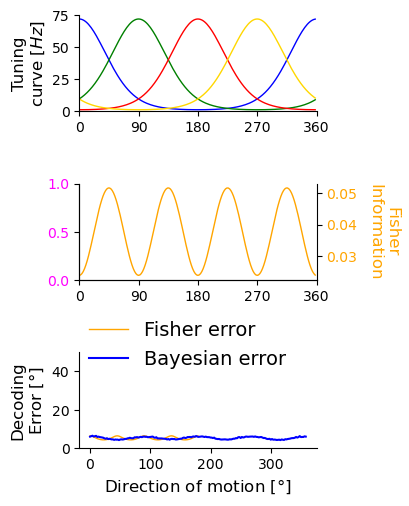

In [248]:
labelsize = 12
legend_fontsize = 14
text_size = 14
tick_labelsize = 10
lw = 1

plt.rcParams['xtick.labelsize']=tick_labelsize
plt.rcParams['ytick.labelsize']=tick_labelsize
mpl.rcParams['axes.spines.right']=False

# setup plot
fig = plt.figure(figsize=(15, 10))
gs = GS(5, 4, wspace=0.3, hspace=0.75)
colors = ['blue', 'green', 'red', 'gold']

# Tuning curves ----------------
ax = fig.add_subplot(gs[0,0])
for j, tc in enumerate(tuning_c):
    ax.plot(stim, tc, color = colors[j], linewidth=lw)

# legend
ax.set_xlim(0,360)
ax.set_ylim(0,75)    
ax.set_xticks(np.arange(0,361, 90))
ax.set_yticks(np.arange(0,76, 25))

# Fisher information ----------------
ax1 = fig.add_subplot(gs[1,0])
ax2 = ax1.twinx()
ax2.plot(stim, fisher_info, color = 'orange', linewidth=lw)
ax2.spines['right'].set_visible(True)
ax1.tick_params('y', labelcolor = 'magenta')
ax2.tick_params('y', labelcolor = 'orange')
ax1.set_xlim(0,360)
ax1.set_xticks(np.arange(0,361, 90))
# ax1.set_ylabel('Sensitivity\n'+r'[$Bits$]', color = 'magenta', size = labelsize)

ax.yaxis.set_label_coords(-0.135, y=0.5)
ax.set_ylabel('Tuning\n'+r'curve [$Hz$]', size = labelsize)  

ax2.yaxis.set_label_coords(1.35, y=0.5)
ax2.set_ylabel('Fisher\n'+r'Information', rotation=270, color = 'orange', size = labelsize)        

#gs.update(left=0.055,right=0.925,top=0.95,bottom=0.05)#,wspace=0.3,hspace=0.5)
#ax2.set_xlabel(r'Direction of motion [$\degree$]', size = labelsize)

ax3 = fig.add_subplot(gs[2,0])
ax3.plot(fisher_error, color = 'orange', linewidth=lw, label='Fisher error')
ax3.set_xlabel('Direction of motion [$\degree$]', size = labelsize)
ax3.set_ylabel('Decoding\n'+r'Error [$\degree$]', size = labelsize)  

ax3.plot(stim, bayes_data['stds_deg'], color = 'blue', label='Bayesian error')
ax3.legend(frameon=False, fontsize = legend_fontsize, loc=(0.01, 0.75))
ax3.set_ylim(0,50) 

plt.tight_layout()
# plt.legend()

# plt.savefig('basic_model_fisher_info.svg', bbox_inches='tight', dpi = 300)